 For this exercise I'll attempt to apply an already pre-trained model and then add my own layers to classify images in a dataset. The classification is done on a dataset containing more than 3000 images of digits, capital and lowercase letters. The dataset is taken from kaggle and can be found [here](https://www.kaggle.com/datasets/dhruvildave/english-handwritten-characters-dataset). The dataset contains 62 classes, 26 capital letters, 26 lowercase letters and 10 digits. The images have size of 70 by 50. The goal is to build a model that can classify the images into the correct class. 

In [199]:
import matplotlib.pyplot as plt
import random
import os
from PIL import Image
import numpy as np
import tensorflow as tf
import pandas as pd
from prompt_toolkit.input import Input
from sklearn.preprocessing import LabelEncoder
import keras
from sklearn.model_selection import train_test_split
import keras.src.layers as layers


In [200]:
print(tf.__version__)

2.17.0


## Load the dataset
To start the exercise, I'll first load the dataset and take a look at the images. I'll also load the CSV file containing the labels for the images. 

In [201]:
folder_path = "E:\\letters\\img"
folder_display = "E:\\letters\\resized_img_sorted"

data = "E:\\letters\\english.csv"

df = pd.read_csv(data)

In [202]:
labels = df['label'].values     

label_encoder = LabelEncoder()

all_labels = df['label'].unique()
label_encoder.fit(all_labels)

LabelEncoder()

## Display some of the images

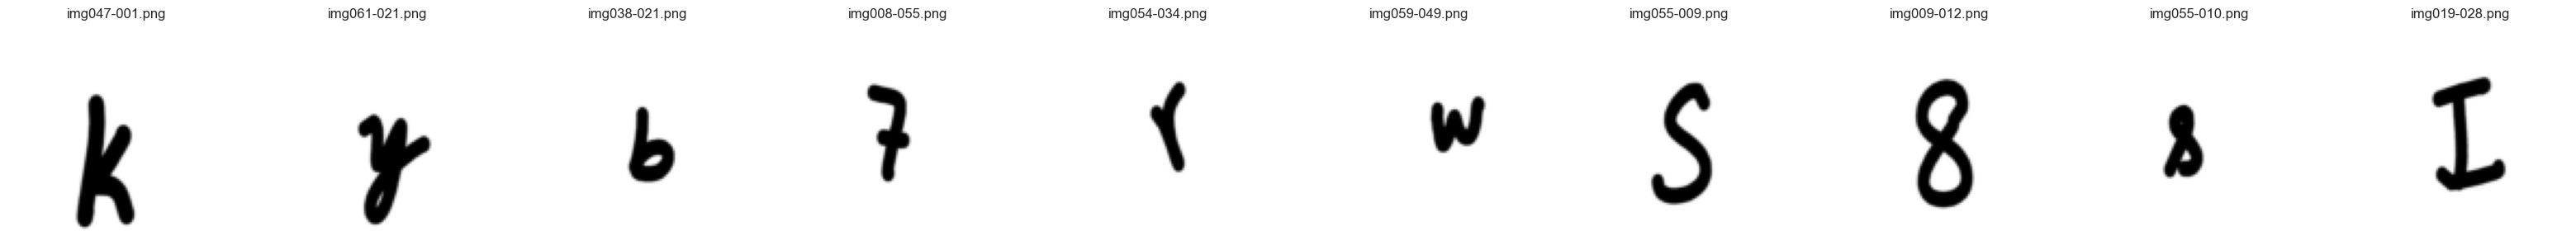

In [203]:
image_files = os.listdir(folder_display)
random.shuffle(image_files)
plt.figure(figsize=(40, 40))
for i in range(10):
    plt.subplot(1, 10, i+1)
    image = Image.open(os.path.join(folder_display, image_files[i]))
    plt.imshow(image)
    plt.title(image_files[i])
    plt.axis('off')

## Preprocess the images
Here the images are resized and as far as the labes go, they are encoded using the LabelEncoder. The images are then added to a numpy array and the labels are added to a numpy array.

In [204]:

X = []
y = []

for index, row in df.iterrows():
    file_name = row['image']
    label = row['label']
    if file_name.endswith('.png'):
        image_path = os.path.join(folder_path, file_name)
        img = plt.imread(image_path)
        img = tf.image.resize(img, (224, 224))
        
        X.append(img)
        y.append(label)

X = np.array(X)
y = np.array(y)

In [205]:
X.min(), X.max()

(0.0, 1.0)

In [206]:
X.shape

(3410, 224, 224, 3)

In [207]:
y = label_encoder.transform(y)

## Split the data into training and testing sets

In [208]:
# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [209]:
# shape of training and testing sets
(X_train.shape, y_train.shape), (X_test.shape, y_test.shape)

(((2728, 224, 224, 3), (2728,)), ((682, 224, 224, 3), (682,)))

## Data Augmentation

In [210]:
from keras.src.legacy.preprocessing.image import ImageDataGenerator

datagen = ImageDataGenerator(
    rotation_range=10,
    width_shift_range=0.1,
    height_shift_range=0.1,
    zoom_range=0.1,
    horizontal_flip=False,
    validation_split=0.2
)

## Transfer Learning
Here I will use a pre-trained model and add my own layers to classify the images. I'll use the ResNet50 model as the base model and add my own layers to classify the images. The reason for choosing the ResNet50 model is that it is a pre-trained model that has been trained on the ImageNet dataset. The model has 50 layers and is able to classify images into 1000 classes.(https://medium.com/@nitishkundu1993/exploring-resnet50-an-in-depth-look-at-the-model-architecture-and-code-implementation-d8d8fa67e46f) I'll add my own layers to classify the images into the 62 classes. The model will be trained on the training data and evaluated on the test data. The pretrained model is not trainable, only the layers that I add are trainable.

In [211]:
from keras.src.applications.resnet import ResNet50
from keras import layers, models


base_model = ResNet50(weights='imagenet', include_top=False, input_shape=X_train.shape[1:])
base_model.trainable = False
base_model.summary()

model = models.Sequential([
    base_model,
    layers.Flatten(),
    layers.Dense(256, activation='relu'),
    layers.Dense(128, activation='relu'),
    layers.Dense(62, activation='softmax')
])

94765736/94765736 ━━━━━━━━━━━━━━━━━━━━ 10s 0us/step


Model: "resnet50"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_18      │ (None, 224, 224,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1_pad           │ (None, 230, 230,  │          0 │ input_layer_18[0… │
│ (ZeroPadding2D)     │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1_conv (Conv2D) │ (None, 112, 112,  │      9,472 │ conv1_pad[0][0]   │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1_bn            │ (None, 112, 112,  │        256 │ conv1_conv[0][0]  │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1_relu          │ (None, 112, 112,  │          0 │ conv1_bn[0][0]    │
│ (Activation)        │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ pool1_pad           │ (None, 114, 114,  │          0 │ conv1_relu[0][0]  │
│ (ZeroPadding2D)     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ pool1_pool          │ (None, 56, 56,    │          0 │ pool1_pad[0][0]   │
│ (MaxPooling2D)      │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_1_conv │ (None, 56, 56,    │      4,160 │ pool1_pool[0][0]  │
│ (Conv2D)            │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_1_bn   │ (None, 56, 56,    │        256 │ conv2_block1_1_c… │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_1_relu │ (None, 56, 56,    │          0 │ conv2_block1_1_b… │
│ (Activation)        │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_2_conv │ (None, 56, 56,    │     36,928 │ conv2_block1_1_r… │
│ (Conv2D)            │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_2_bn   │ (None, 56, 56,    │        256 │ conv2_block1_2_c… │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_2_relu │ (None, 56, 56,    │          0 │ conv2_block1_2_b… │
│ (Activation)        │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_0_conv │ (None, 56, 56,    │     16,640 │ pool1_pool[0][0]  │
│ (Conv2D)            │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_3_conv │ (None, 56, 56,    │     16,640 │ conv2_block1_2_r… │
│ (Conv2D)            │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_0_bn   │ (None, 56, 56,    │      1,024 │ conv2_block1_0_c… │
│ (BatchNormalizatio… │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_3_bn   │ (None, 56, 56,    │      1,024 │ conv2_block1_3_c

 Total params: 23,587,712 (89.98 MB)

 Trainable params: 0 (0.00 B)

 Non-trainable params: 23,587,712 (89.98 MB)

## Compile the model
I'll compile the model using the Adam optimizer and the sparse_categorical_crossentropy loss function. I'll train the model for 20 epochs with a batch size of 64. I experimented with different epochs and batch sizes and found that 20 epochs and a batch size of 64 gave the best results.

In [212]:
model.compile(optimizer='adam',
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])
reduce_lr = keras.callbacks.ReduceLROnPlateau(factor=0.5, patience=5)
early_stopping = keras.callbacks.EarlyStopping(patience=10, restore_best_weights=True)

### Train the model
As you can see below the model is trained for 20 epochs on the augmented data. I tried different batch sizes and 64 gave the best results. The training loss and accuracy are plotted against the test loss and accuracy. The model is providing interesting results with not as high of an accuracy as I was hoping for. The problem might be that the model is too complex for the dataset. The model could be improved by using a handmade CNN model.

In [213]:
history = model.fit(
    datagen.flow(X_train, y_train, batch_size=64, subset='training'),
    validation_data=datagen.flow(X_train, y_train, batch_size=64, subset='validation'),
    epochs=20,
    callbacks=[reduce_lr, early_stopping]
)

Epoch 1/20


C:\Users\metos\miniconda3\Lib\site-packages\keras\src\trainers\data_adapters\py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


35/35 ━━━━━━━━━━━━━━━━━━━━ 74s 2s/step - accuracy: 0.0414 - loss: 6.9294 - val_accuracy: 0.1119 - val_loss: 3.5904 - learning_rate: 0.0010
Epoch 2/20
35/35 ━━━━━━━━━━━━━━━━━━━━ 68s 2s/step - accuracy: 0.1583 - loss: 3.2929 - val_accuracy: 0.2807 - val_loss: 2.7638 - learning_rate: 0.0010
Epoch 3/20
35/35 ━━━━━━━━━━━━━━━━━━━━ 67s 2s/step - accuracy: 0.3228 - loss: 2.5687 - val_accuracy: 0.2881 - val_loss: 2.7129 - learning_rate: 0.0010
Epoch 4/20
35/35 ━━━━━━━━━━━━━━━━━━━━ 66s 2s/step - accuracy: 0.3965 - loss: 2.1931 - val_accuracy: 0.3376 - val_loss: 2.4648 - learning_rate: 0.0010
Epoch 5/20
35/35 ━━━━━━━━━━━━━━━━━━━━ 67s 2s/step - accuracy: 0.4112 - loss: 2.0410 - val_accuracy: 0.4404 - val_loss: 1.8992 - learning_rate: 0.0010
Epoch 6/20
35/35 ━━━━━━━━━━━━━━━━━━━━ 68s 2s/step - accuracy: 0.5196 - loss: 1.6424 - val_accuracy: 0.4862 - val_loss: 1.7617 - learning_rate: 0.0010
Epoch 7/20
35/35 ━━━━━━━━━━━━━━━━━━━━ 67s 2s/step - accuracy: 0.5594 - loss: 1.5298 - val_accuracy: 0.5083 - va

In [214]:
X_test.shape

(682, 224, 224, 3)

In [215]:
predict = model.predict(X_test)


22/22 ━━━━━━━━━━━━━━━━━━━━ 15s 656ms/step


## Evaluate the model
I'll evaluate the model using the test data. The model gives an accuracy of around 0.7 on the test data. As you can see by the plot bellow when we follow the test and train curve, the train and test don't exactly overlap. By looking at the plot we can conclude that the model is a little bit overfitting the data. One improvement could be to add a Dropout layer to the model to prevent overfitting. As I have already tried to augment the data to prevent the overfit from happening, the model is still overfitting the data.

In [216]:
def plot_training_history(history):
    fig, axs = plt.subplots(1, 2, figsize=(12, 6))

    axs[0].plot(history.history['loss'], label='train loss')
    axs[0].plot(history.history['val_loss'], label='test loss')
    axs[0].set_title('Loss')
    axs[0].legend()

    axs[1].plot(history.history['accuracy'], label='train accuracy')
    axs[1].plot(history.history['val_accuracy'], label='test accuracy')
    axs[1].set_title('Accuracy')
    axs[1].set_xlabel('Epochs - Nos. of rounds')
    axs[1].set_ylabel('Accuracy')
    axs[1].legend()

    plt.show()

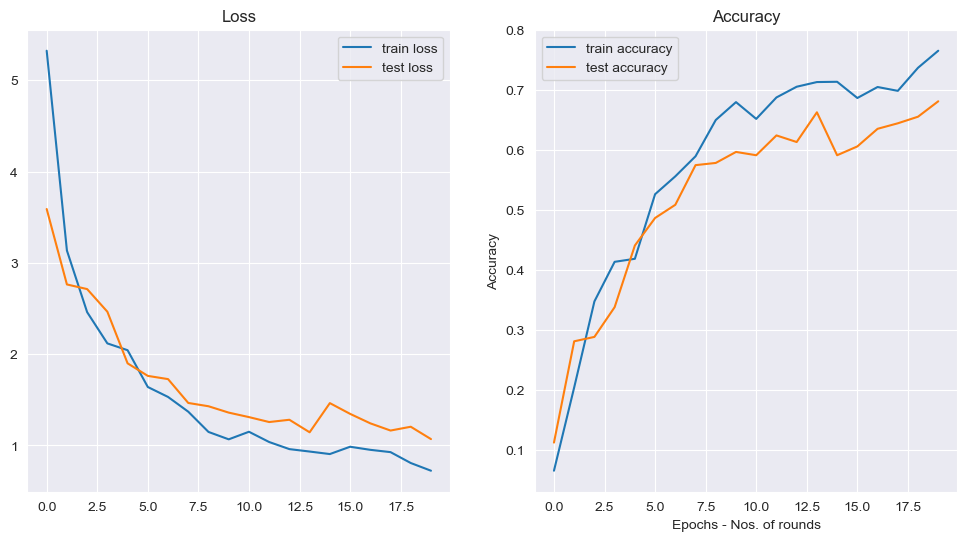

In [217]:
plot_training_history(history)

In [218]:
#evaluate the model
model.evaluate(X_test, y_test)


22/22 ━━━━━━━━━━━━━━━━━━━━ 13s 603ms/step - accuracy: 0.6738 - loss: 1.0047


[0.9898373484611511, 0.6862170100212097]

### Classification report
As it can be seen below, the model is performing well on the test data. The classification report shows that the model is performing well on all classes. The model could be improved by using a less complex model or by using a different CNN model architecture.
The model has trouble differentiating between letters and numbers that resemble eachother like 'O' and '0'. The model also has trouble differentiating between 'I' and 'l'.  

In [219]:
from sklearn.metrics import classification_report
y_pred = model.predict(X_test)
y_pred = np.argmax(y_pred, axis=1)
print(classification_report(y_test, y_pred, target_names=all_labels))

22/22 ━━━━━━━━━━━━━━━━━━━━ 13s 607ms/step
              precision    recall  f1-score   support

           0       0.36      0.29      0.32        14
           1       0.46      0.55      0.50        11
           2       0.38      0.80      0.52        10
           3       0.83      0.50      0.62        20
           4       1.00      0.50      0.67        14
           5       0.87      0.81      0.84        16
           6       1.00      0.89      0.94         9
           7       0.79      0.73      0.76        15
           8       0.71      0.83      0.77        12
           9       0.69      0.82      0.75        11
           A       0.94      0.94      0.94        16
           B       1.00      0.67      0.80         9
           C       0.62      0.89      0.73         9
           D       0.83      1.00      0.91        10
           E       1.00      0.80      0.89        15
           F       1.00      0.71      0.83        14
           G       0.83      1.00      

### Confusion matrix
The confusion matrix shows the true labels against the predicted labels. The model is performing well on most classes, but it has trouble differentiating between 'O' and '0' and 'I' and 'l'.

22/22 ━━━━━━━━━━━━━━━━━━━━ 14s 610ms/step


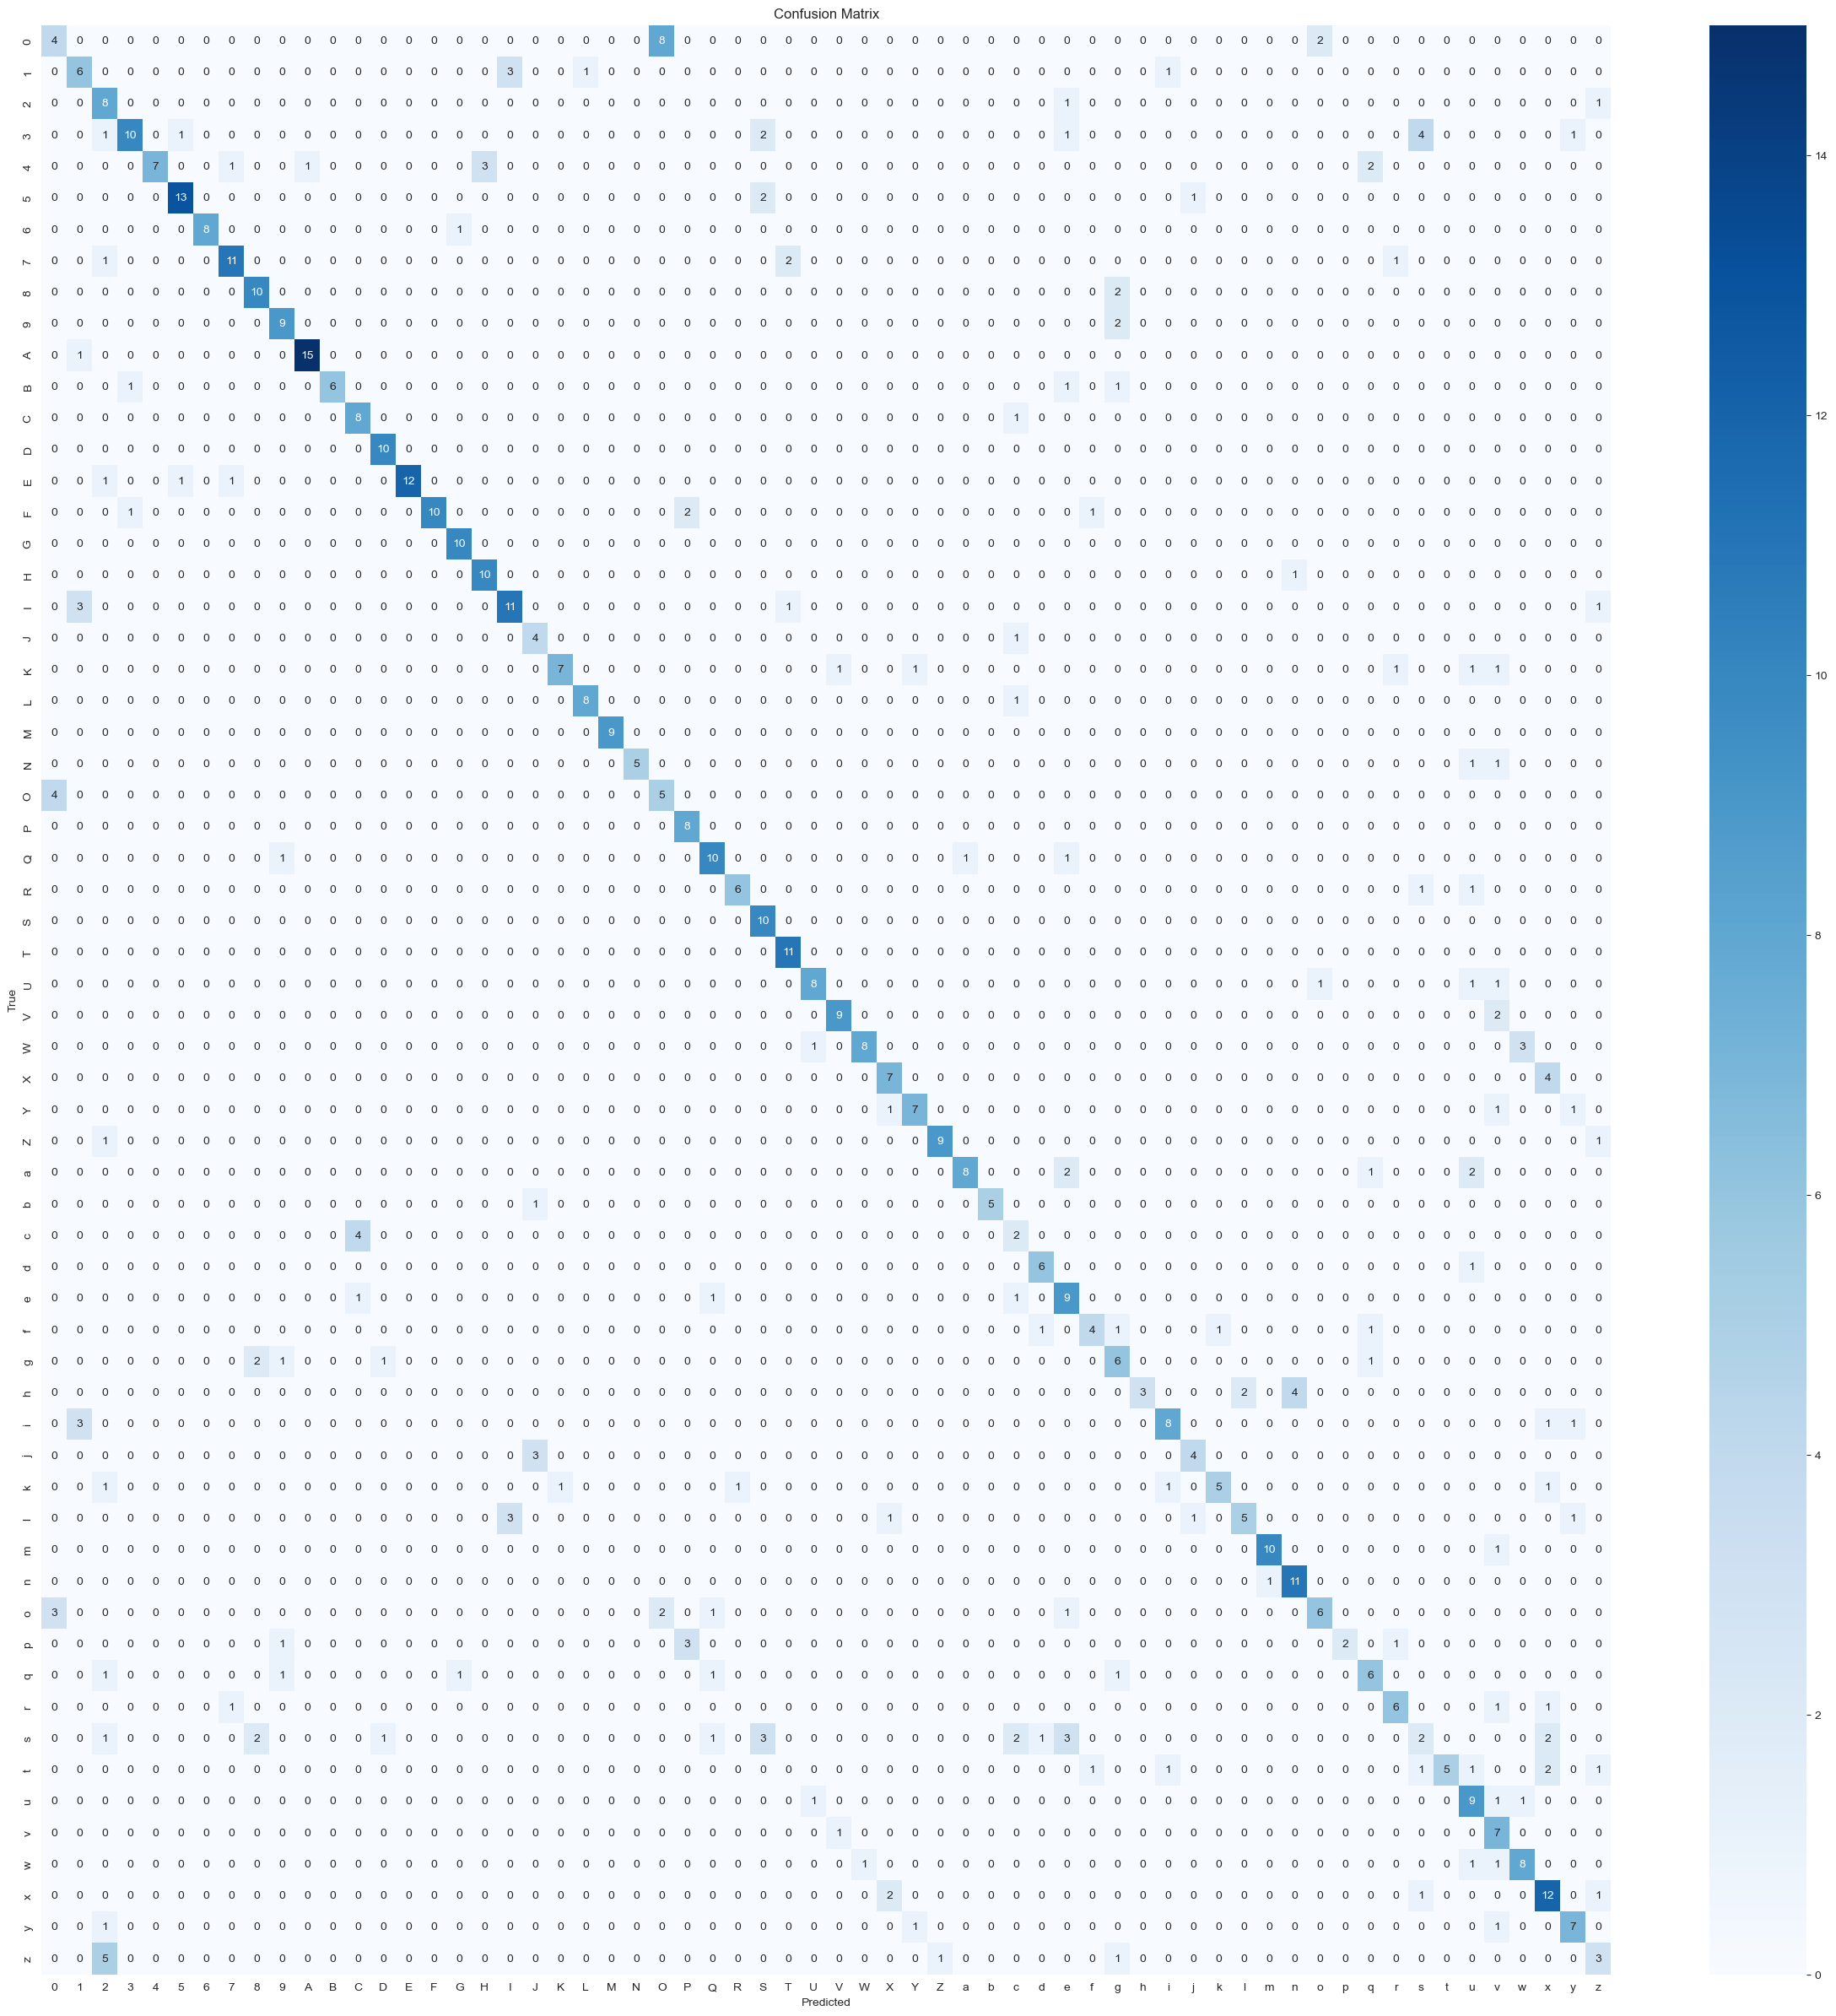

In [220]:
from sklearn.metrics import confusion_matrix
import seaborn as sns

y_pred = model.predict(X_test)
y_pred_classes = np.argmax(y_pred, axis=1)

cm = confusion_matrix(y_test, y_pred_classes)

class_labels = label_encoder.classes_

plt.figure(figsize=(30, 30))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', 
            xticklabels=class_labels, yticklabels=class_labels)
plt.xlabel('Predicted') 
plt.ylabel('True')
plt.title('Confusion Matrix')
plt.show()


## Test the model
I'll test the model on 10 random images from the test data. The model is performing well on the test data as it is able to predict the correct class for most of the images.

In [221]:
# test the model
def test_model(model, X_test, y_test, n=10):
    for i in range(n):
        index = random.randint(0, X_test.shape[0])
        image = X_test[index]
        label = y_test[index]
        image = np.expand_dims(image, axis=0)
        prediction = model.predict(image)
        predicted_label = np.argmax(prediction)
        predicted_label = label_encoder.inverse_transform([predicted_label])[0]
        true_label = label_encoder.inverse_transform([label])[0]
        plt.figure(figsize=(4, 4))
        plt.imshow(image[0])
        plt.title(f'True label: {true_label}\nPredicted label: {predicted_label}')
        plt.axis('off')
        plt.show()

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step


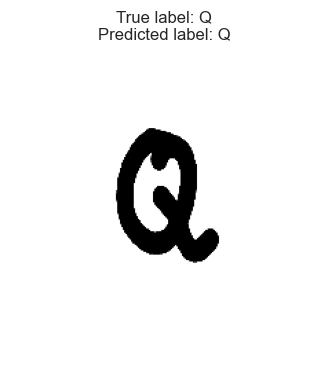

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step


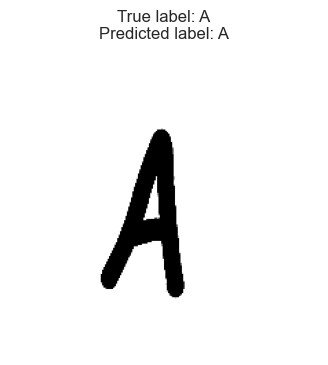

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step


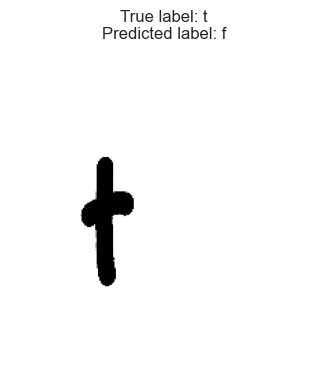

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step


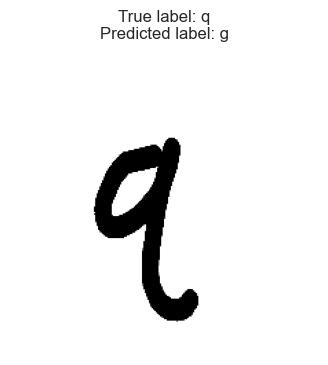

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step


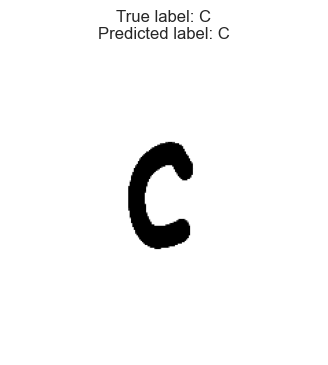

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step


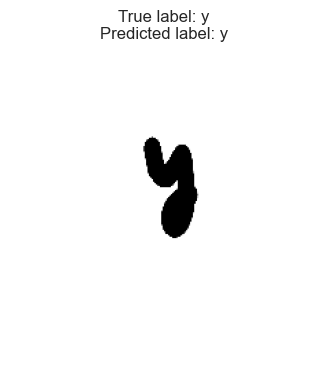

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step


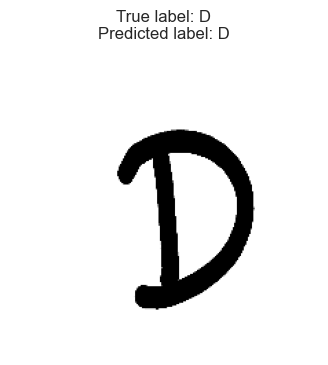

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step


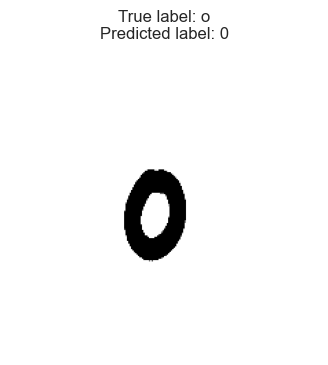

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step


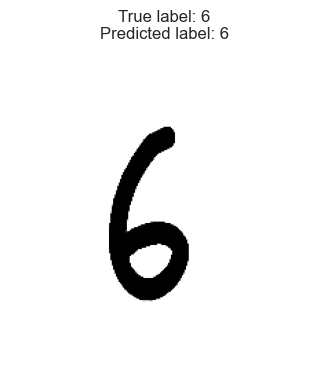

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step


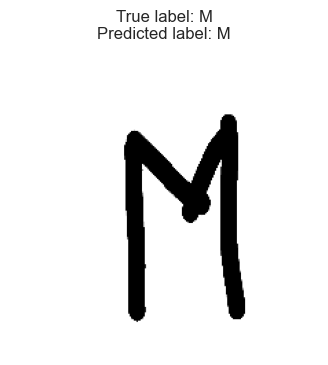

In [222]:
test_model(model, X_test, y_test, 10)

# What did I learn?
During the making of this exercise I learned how to apply a pre-trained model to a data-set model using the keras ResNet50 pre-trained model. The whole concept of the CNN is that it uses convolutional layers to automatically detect patterns, such as edges or textures, through convolution operations, reducing data size while preserving important features for tasks like classification or detection, but I'm starting to understand how the model works. I also learned how to use the ImageDataGenerator to augment the data.
